In [1]:
'''
Function Description：使用现有的VGG16搭建一个神经网络以实现乳腺癌分子分型的分类
'''
import tensorflow as tf 
import os
import numpy as np 
#加载训练数据
#以下是train和test的图片集合
batch_size = 20
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
num_epochs = 100
class_names = ['Her2', 'luminal_A', 'luminal_B', 'TN']#每个分类的名称

In [2]:
#获取train的文件路径
train_data_dir = 'F:/分子分型/X线MRI共有/MRI_minbox/train'
validation_data_dir = 'F:/分子分型/X线MRI共有/MRI_minbox/validation'
Her2_train_data_dir = train_data_dir + '/Her_2/'
luminal_A_train_data_dir = train_data_dir + '/luminal_A/'
luminal_B_train_data_dir = train_data_dir + '/luminal_B/'
TN_train_data_dir = train_data_dir + '/TN/'

#将train的图片名依次读取
Her2_train_data_name = [Her2_train_data_dir + filename for filename in os.listdir(Her2_train_data_dir)]
luminal_A_train_data_name = [luminal_A_train_data_dir + filename for filename in os.listdir(luminal_A_train_data_dir)]
luminal_B_train_data_name = [luminal_B_train_data_dir + filename for filename in os.listdir(luminal_B_train_data_dir)]
TN_train_data_name = [TN_train_data_dir + filename for filename in os.listdir(TN_train_data_dir)]

train_data_name = Her2_train_data_name + luminal_A_train_data_name + luminal_B_train_data_name + TN_train_data_name
train_data_name = tf.convert_to_tensor(train_data_name)

#用0,1,2,3分别代表四种类型
train_data_labels = [0]* len(Her2_train_data_name) + [1]*len(luminal_A_train_data_name) + [2]*len(luminal_B_train_data_name) + [3] * len(TN_train_data_name)
train_data_labels = tf.convert_to_tensor(train_data_labels, dtype=tf.int64)
#train_data_name = np.array(train_data_name)
#train_data_labels = np.array(train_data_labels)


In [3]:
print(train_data_name.shape)
print(train_data_labels.shape)

(583,)
(583,)


In [4]:
print(len(Her2_train_data_name), len(luminal_A_train_data_name), len(luminal_B_train_data_name), len(TN_train_data_name))

189 125 148 121


In [5]:
#获取验证图像的文家路径
Her2_val_data_dir = validation_data_dir + '/Her_2/'
luminal_A_val_data_dir = validation_data_dir + '/luminal_A/'
luminal_B_val_data_dir = validation_data_dir + '/luminal_B/'
TN_val_data_dir = validation_data_dir + '/TN/'
#获取验证图像的文件名称
Her2_val_data_name = [Her2_val_data_dir + filename for filename in os.listdir(Her2_val_data_dir)]
luminal_A_val_data_name = [luminal_A_val_data_dir + filename for filename in os.listdir(luminal_A_val_data_dir)]
luminal_B_val_data_name = [luminal_B_val_data_dir + filename for filename in os.listdir(luminal_B_val_data_dir)]
TN_val_data_name = [TN_val_data_dir + filename for filename in os.listdir(TN_val_data_dir)]
val_data_name = Her2_val_data_name + luminal_A_val_data_name + luminal_B_val_data_name + TN_val_data_name

val_data_labels = [0] * len(Her2_val_data_name) + [1] * len(luminal_A_val_data_name) + [2] * len(luminal_B_val_data_name) + [3] * len(TN_val_data_name)
#val_data_name = np.array(val_data_name)
#val_data_labels = np.array(val_data_labels)
val_data_name = tf.convert_to_tensor(val_data_name)
val_data_labels = tf.convert_to_tensor(val_data_labels)

In [6]:
print(val_data_name.shape)
print(val_data_labels.shape)

(250,)
(250,)


In [7]:
#创建映射函数
def _map(imagename, label):
    image_string = tf.io.read_file(imagename)
    image_decoded = tf.image.decode_png(image_string, channels = 1)
    image_resize = tf.image.resize(image_decoded, [28,28])/255.0
    label = tf.cast(label, dtype=tf.int32)
    return image_resize, label


In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_name, train_data_labels))


In [9]:
train_dataset = train_dataset.map(
    map_func = _map,
    num_parallel_calls= tf.data.experimental.AUTOTUNE
)

In [10]:
#对训练集合做出设定， 
train_dataset = train_dataset.shuffle(buffer_size = 1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_data_name, val_data_labels))
val_dataset = val_dataset.map(_map).batch(batch_size)

In [12]:
print(train_dataset, val_dataset)# dataset 本身无法方便地获取元素

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)> <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)>


In [13]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, activation = tf.nn.relu, input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = tf.nn.relu),
    tf.keras.layers.Dense(64, activation = tf.nn.relu),
    tf.keras.layers.Dense(4, activation = tf.nn.sigmoid)
])
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

In [14]:
history = model1.fit(train_dataset, validation_data = val_dataset, epochs = 40)

Epoch 1/40
30/30 [==============================] - 1s 26ms/step - loss: 10.6363 - sparse_categorical_accuracy: 0.3139 - val_loss: 10.8958 - val_sparse_categorical_accuracy: 0.3240
Epoch 2/40
30/30 [==============================] - 0s 8ms/step - loss: 10.8928 - sparse_categorical_accuracy: 0.3242 - val_loss: 10.8958 - val_sparse_categorical_accuracy: 0.3240
Epoch 3/40
30/30 [==============================] - 0s 7ms/step - loss: 10.8928 - sparse_categorical_accuracy: 0.3242 - val_loss: 10.8958 - val_sparse_categorical_accuracy: 0.3240
Epoch 4/40
30/30 [==============================] - 0s 7ms/step - loss: 10.8928 - sparse_categorical_accuracy: 0.3242 - val_loss: 10.8958 - val_sparse_categorical_accuracy: 0.3240
Epoch 5/40
30/30 [==============================] - 0s 7ms/step - loss: 10.8928 - sparse_categorical_accuracy: 0.3242 - val_loss: 10.8958 - val_sparse_categorical_accuracy: 0.3240
Epoch 6/40
30/30 [==============================] - 0s 7ms/step - loss: 10.8928 - sparse_categorica

<Figure size 432x288 with 0 Axes>

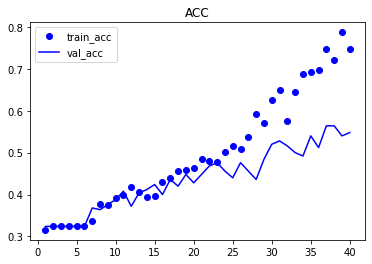

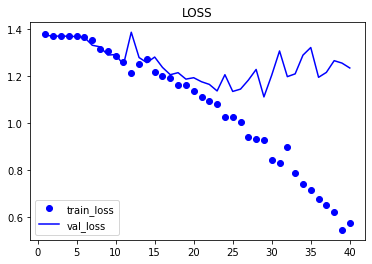

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt 
#获取训练数据
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
#绘制训练图
epochs = range(1, len(val_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'train_acc')
plt.plot(epochs, val_acc, 'b', label = 'val_acc')
plt.title('ACC')
plt.legend()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label = 'train_loss')
plt.plot(epochs, val_loss, 'b', label = 'val_loss')
plt.title('LOSS')
plt.legend()
plt.figure()